In [2]:
import numpy as np
import pandas as pd
import json
import re
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as colors
import pandas as pd
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer as Tfidf
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as dt
from sklearn.decomposition import PCA
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split as sk_split
from sklearn.decomposition import TruncatedSVD as SVD
from sklearn import preprocessing
from sklearn import svm
from sklearn.svm import LinearSVC

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer

%matplotlib inline

/Users/JSoyinka/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
data = []
with open('reviews.json') as f:
    for line in f:
        data.append(json.loads(line))
        
for rev in data:
    rev['cool'] = rev['votes']['cool']
    rev['funny'] = rev['votes']['funny']
    rev['useful'] = rev['votes']['useful']
    del rev['votes']

In [7]:
reviews.duplicated(subset=['business_id', 'text', 'date', 'user_id'])
before = reviews.shape[0]
reviews = reviews.drop(reviews[reviews.duplicated(subset=['business_id', 'text', 'date', 'user_id'])].index)
after = reviews.shape[0]

print before - after, "duplicates dropped"

reviews_2015 = reviews[(reviews['date'] >= '2015-01-01') & (reviews['date'] < '2016-01-01')]
del reviews_2015['review_id']
del reviews_2015['type']

print reviews_2015.shape
reviews_2015.to_json("json_2015.json", orient='records')

AttributeError: 'dict' object has no attribute 'duplicated'

In [6]:
data = pd.read_json('json_2015.json')
data.head()

,business_id,cool,date,funny,stars,text,useful,user_id
0,vT12uXtdBQ10_lUcl-M40w,0,2015-01-01,0,1,terrible experience....I am a local first of a...,0,C_xtIn19eKivN335dzjadg
1,aWMxTWSEqBvH2KhdGPLibQ,0,2015-01-01,0,3,Bad service at this location.\n\nGood iced cof...,0,T7J9ae0wTskrI_Bgwp-4cA
2,Z98h1BhssZeFfZvcVTYOpw,0,2015-01-01,0,2,We have been to Maya's many times since it fir...,1,O7WaUuYwX45Ia6Mvf01UCw
3,3rwM9fPYPk9qDkEBOhyHbg,1,2015-01-01,0,5,"booked the hotel for new years, over the phone...",1,kq-4vbC1cHQbRKyDmwERSA
4,JpYn_HdxQNZQSlWWv4P6Iw,0,2015-01-01,0,3,"Good, not great. Not a ton of tea options but ...",1,XweddetOpWNuJQ5mLb_5JQ


In [7]:
samp = data.sample(50000) #draw samples

In [8]:
vectorizer = CountVectorizer(stop_words='english', binary=False, max_features=10000) #using non-binary Count Vec.
reviews = samp.text.values

#tokenize words
x = vectorizer.fit_transform(reviews)

In [9]:
binary_y = [] #class observations according to whether they have at least one "helpful" vote

for score in samp.useful.values:
    i = 1 if score > 0 else 0
    binary_y.append(i)

C= 0.0001 : 0.646140014067
C= 0.001 : 0.662779856527
C= 0.01 : 0.66393987653
C= 0.1 : 0.653520002091
C= 1 : 0.627160042005
C= 10 : 0.606280070737
C= 100 : 0.600379882726


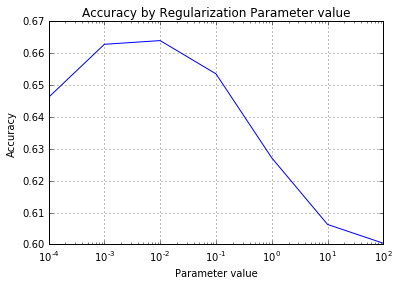

In [10]:
cvals = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
scores = []
for c in cvals: #try cross validating the data with different regularization parameters
    log_model = LogReg(C=c, penalty='l2') #initiate unregularized logistic regression model
    score = cross_val_score(log_model, x, binary_y, n_jobs=-1).mean() #cross validate
    scores.append(score)
    print "C=",c ,":", score
    
    
plt.plot(cvals, scores)
plt.xscale('log')
plt.title("Accuracy by Regularization Parameter value")
plt.xlabel("Parameter value")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

In [11]:
log_model = LogReg(C=0.01, penalty='l2') #initialize logistic regression model
print "Cross Validated Accuracy on Sample:", cross_val_score(log_model, x, binary_y, n_jobs=-1).mean()

Cross Validated Accuracy on Sample: 0.66393987653


In [12]:
log_model = LogReg(C=0.01, penalty='l2') #initialize logistic regression model
log_model.fit(x, binary_y)
y_pred = log_model.predict(x)
binary_y = np.array(binary_y)

tn, fp, fn, tp = confusion_matrix(binary_y, y_pred).ravel() #from sklearn docs

print "NO CLASS BALANCE CORRECTION"
print confusion_matrix(binary_y, y_pred)
print
print "False Positive Rate:", fp/float(fp+tn)
print "False Negative Rate:", fn/float(fn+tp)
print "True Positive Rate:", tp/float(tp+fp)
print "True Negative Rate:", tn/float(tn+fn)
print
print "Accuracy on Positive Reviews:", np.mean(y_pred[binary_y == 1] == binary_y[binary_y == 1])
print "Accuracy on Negative Reviews:", np.mean(y_pred[binary_y == 0] == binary_y[binary_y == 0])

print "Overall F1 Score:", cross_val_score(log_model, x, binary_y, n_jobs=-1, scoring='f1').mean()

#BALANCED CLASSES
log_model = LogReg(C=0.01, penalty='l2', class_weight='balanced') #initialize logistic regression model
log_model.fit(x, binary_y)
y_pred = log_model.predict(x)
binary_y = np.array(binary_y)

tn, fp, fn, tp = confusion_matrix(binary_y, y_pred).ravel() #from sklearn docs

print "\n\nWITH CLASS BALANCE CORRECTION"
print confusion_matrix(binary_y, y_pred)
print
print "False Positive Rate:", fp/float(fp+tn)
print "False Negative Rate:", fn/float(fn+tp)
print "True Positive Rate:", tp/float(tp+fp)
print "True Negative Rate:", tn/float(tn+fn)
print
print "Accuracy on Positive Reviews:", np.mean(y_pred[binary_y == 1] == binary_y[binary_y == 1])
print "Accuracy on Negative Reviews:", np.mean(y_pred[binary_y == 0] == binary_y[binary_y == 0])

print "Overall F1 Score:", cross_val_score(log_model, x, binary_y, n_jobs=-1, scoring='f1').mean()

NO CLASS BALANCE CORRECTION
[[28903  2247]
 [12761  6089]]

False Positive Rate: 0.0721348314607
False Negative Rate: 0.676976127321
True Positive Rate: 0.730446257198
True Negative Rate: 0.693716397849

Accuracy on Positive Reviews: 0.323023872679
Accuracy on Negative Reviews: 0.927865168539
Overall F1 Score: 0.377639697816


WITH CLASS BALANCE CORRECTION
[[24119  7031]
 [ 8301 10549]]

False Positive Rate: 0.225714285714
False Negative Rate: 0.440371352785
True Positive Rate: 0.600056882821
True Negative Rate: 0.743954349167

Accuracy on Positive Reviews: 0.559628647215
Accuracy on Negative Reviews: 0.774285714286
Overall F1 Score: 0.512523895903


In [13]:
#same procedure on full dataset

vectorizer = CountVectorizer(stop_words='english', binary=False, max_features=10000) #using non-binary Count Vec.
reviews = data.text.values
x = vectorizer.fit_transform(reviews)

binary_y = []

for score in data.useful.values:
    i = 1 if score > 0 else 0
    binary_y.append(i)

In [14]:
log_model = LogReg(C=0.01, penalty='l2', class_weight='balanced') #initialize logistic regression model
print "Accuracy:", cross_val_score(log_model, x, binary_y, n_jobs=-1).mean()
print "F1 Score:",cross_val_score(log_model, x, binary_y, scoring='f1', n_jobs=-1).mean()

log_model.fit(x, binary_y)
y_pred = log_model.predict(x)
binary_y = np.array(binary_y)

tn, fp, fn, tp = confusion_matrix(binary_y, y_pred).ravel() #from sklearn docs

print "\n\nWITH CLASS BALANCE CORRECTION"
print confusion_matrix(binary_y, y_pred)
print
print "False Positive Rate:", fp/float(fp+tn)
print "False Negative Rate:", fn/float(fn+tp)
print "True Positive Rate:", tp/float(tp+fp)
print "True Negative Rate:", tn/float(tn+fn)
print
print "Accuracy on Positive Reviews:", np.mean(y_pred[binary_y == 1] == binary_y[binary_y == 1])
print "Accuracy on Negative Reviews:", np.mean(y_pred[binary_y == 0] == binary_y[binary_y == 0])

print "Overall F1 Score:", cross_val_score(log_model, x, binary_y, n_jobs=-1, scoring='f1').mean()

Accuracy: 0.655814588905
F1 Score: 0.525511083732


WITH CLASS BALANCE CORRECTION
[[314277 101194]
 [119596 131748]]

False Positive Rate: 0.243564532783
False Negative Rate: 0.475825959641
True Positive Rate: 0.56558284895
True Negative Rate: 0.724352517903

Accuracy on Positive Reviews: 0.524174040359
Accuracy on Negative Reviews: 0.756435467217
Overall F1 Score: 0.525511083732


Overall, while our baseline model establishes some degree of separation between helpful and unhelpful reviews it seems to have a relatively low accuracy and F1 score even when tuned. This is likely due to a confounding element of our question: the reality that reviews can lack "useful" votes for multiple reasons. 

On one hand, a review can have no useful votes when it actually contains useless content. This is the sort of review we'd like to classify as 0 or useless. On the other hand, a great review can recieve no useful votes simply because it goes unnoticed by other Yelp users. This likely impedes our model's capacity to make solid predictions regarding a review's helpfulness. A "denominator" value such as the sort seen in the Amazon dataset we looked at previously would help alleviate this issue.

Given this difficulty, it will make sense for us to fit some additional models to the data to see which works best. Playing with class weights would also make sense, as the model currently seems to be making a fair number of false negative errors (which are severely impacting its performance). We can also explore other proxies for review quality, such as ratios between the different review classifications (useful, cool, funny) for a different review. Our baseline modeling approach is also extensible to direct analysis of the lingustic characteristics correlating with these other classifications.

This model represents a decent start to what will be a more involved and nuanced project. Our next steps will be to play around with other modeling techniques and adjust parameters and inputs/weighting to try to reduce our false postiive and negative rates.

In [15]:
data = pd.read_json('json_2015.json')
data = data.sample(frac=1)

In [16]:
data.head()

,business_id,cool,date,funny,stars,text,useful,user_id
9981,8PJSfnXpHoENxD-rsGGXWA,1,2015-01-06,1,4,I stayed here with a group of friends for the ...,3,CUeJQCLwMl3LocFKNUm2tQ
168112,5mMk3Ted-EOyHvJ-j9BhiQ,6,2015-04-09,5,3,More like a 3.5 for our particular experiences...,7,9A2-wSoBUxlMd3LwmlGrrQ
607345,iUPJmJvHy9fVfRxsuwwdLQ,0,2015-11-26,0,5,What a wonderful experience! Came in a little ...,0,jF4EiSxj3uv1WKR5Lt5ieQ
57328,hUDeQq7KZXx_w7aFxdO-aQ,2,2015-02-05,0,5,I came here six months ago when I was visiting...,1,roEWEvo1EQId1JguoLWISg
570859,qh04JalvbBzHL8xodlmlfg,0,2015-11-06,0,5,Best service ever!! Kasey is a rockstar! \nNo ...,0,H7cL5HQKriVcWVV8bH5WJg


In [17]:
#standardize predictor variables

def scorer_pos(estimator, X, y): #custom scoring functions to get positive and negative accuracy
    y_pred = estimator.predict(X)
    return np.float(np.mean(y_pred[y == 1] == y[y == 1]))

def scorer_neg(estimator, X, y):
    estimator.fit(X, y)
    y_pred = estimator.predict(X)
    return np.float(np.mean(y_pred[y == 0] == y[y == 0]))

In [23]:
def test_model(x, binary_y, model, title, coefs=False):
    model.fit(x, binary_y)
    y_pred = model.predict(x)
    binary_y = np.array(binary_y)

    tn, fp, fn, tp = confusion_matrix(binary_y, y_pred).ravel() #from sklearn docs

    print title
    print confusion_matrix(binary_y, y_pred)

    print "False Positive Rate:", fp/float(fp+tn)
    print "False Negative Rate:", fn/float(fn+tp)
    print "True Positive Rate:", tp/float(tp+fp)
    print "True Negative Rate:", tn/float(tn+fn)
    
    print "Positive Accuracy:", cross_val_score(model, x, binary_y, n_jobs=-1, scoring=scorer_pos).mean()
    print "Negative Accuracy:", cross_val_score(model, x, binary_y, n_jobs=-1, scoring=scorer_neg).mean()
    print "Cross Validated Accuracy on Sample:", cross_val_score(model, x, binary_y, n_jobs=-1).mean()
    print "Cross Validated AUC on Sample:", cross_val_score(model, x, binary_y, n_jobs=-1, scoring='roc_auc').mean()
    print "Train Set Accuracy on Sample:", np.mean(y_pred == binary_y)
    print
    if coefs == True:
        mydict = zip(model.coef_[0], vectorizer.get_feature_names())
        words = sorted([(i[0], i[1].encode('utf-8')) for i in mydict], reverse=True, key=lambda x: x[0])
        return words

In [24]:
stemmer = PorterStemmer()
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    text = re.sub("[^a-zA-Z]", " ", text)
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

In [25]:
samp = data.sample(100000) #draw samples

#lengths = [len(i[1]['text']) for i in samp.iterrows()]

samp.shape
frac_useful = 1 - data['useful'].value_counts()[0] / float(data.shape[0])
frac_funny = 1 - data['funny'].value_counts()[0] / float(data.shape[0])
frac_cool = 1 - data['cool'].value_counts()[0] / float(data.shape[0])

In [26]:
vectorizer = TfidfVectorizer(stop_words='english', 
                             binary=False, 
                             max_features=10000,
                             analyzer='word',
                             #tokenizer=tokenize,
                             sublinear_tf=False
                            ) #using non-binary Count Vec.
reviews = samp.text.values

#tokenize words
x = vectorizer.fit_transform(reviews)

y_useful = [] #class observations according to whether they have at least one "helpful" vote
y_cool = []
y_funny = []


for score in samp.useful.values:
    i = 1 if score > 0 else 0
    y_useful.append(i)

for score in samp.cool.values:
    i = 1 if score > 0 else 0
    y_cool.append(i)

for score in samp.funny.values:
    i = 1 if score > 0 else 0
    y_funny.append(i)

In [27]:
u_tune = 0.00
f_tune = 0.00
c_tune = 0.00

weights = {0:1/(1 - frac_useful + u_tune), 1:1/(frac_useful - u_tune)}
log_model = LogReg(C=0.01, penalty='l2', class_weight=weights) #initialize logistic regression model

rand = RandomForestClassifier(n_estimators=300, criterion='gini', 
                              max_features= 17, max_depth=5, class_weight='balanced')



useful_words = test_model(x, y_useful, 
                          log_model,
                          "Useful",
                          coefs=True)
funny_words = test_model(x, y_funny, 
                         log_model.set_params(class_weight={0:1/(1 - frac_funny + f_tune), 1:1/(frac_funny - f_tune)}), 
                         "Funny",
                          coefs=True)
cool_words = test_model(x, y_cool, 
                        log_model.set_params(class_weight={0:1/(1 - frac_cool + c_tune), 1:1/(frac_cool - c_tune)}),
                        #rand,
                        "Cool",
                          coefs=True)

Useful
[[38657 23529]
 [13939 23875]]
False Positive Rate: 0.378364905284
False Negative Rate: 0.368620087798
True Positive Rate: 0.503649481056
True Negative Rate: 0.734979846376
Positive Accuracy: 0.620696071543
Negative Accuracy: 0.609043857753
Cross Validated Accuracy on Sample: 0.610769927887
Cross Validated AUC on Sample: 0.653549500243
Train Set Accuracy on Sample: 0.62532

Funny
[[52392 30194]
 [ 5666 11748]]
False Positive Rate: 0.365606761437
False Negative Rate: 0.325370391639
True Positive Rate: 0.280101091984
True Negative Rate: 0.902407936891
Positive Accuracy: 0.650338446086
Negative Accuracy: 0.629380255286
Cross Validated Accuracy on Sample: 0.629439905502
Cross Validated AUC on Sample: 0.683893141718
Train Set Accuracy on Sample: 0.6414

Cool
[[50529 27541]
 [ 8573 13357]]
False Positive Rate: 0.352773152299
False Negative Rate: 0.390925672595
True Positive Rate: 0.326592987432
True Negative Rate: 0.854945687117
Positive Accuracy: 0.582261741906
Negative Accuracy: 0.6

In [28]:
print "10 Coolest Words:"
for word in cool_words[:10]:
    print word[1], word[0]

print "\n10 Least Cool Words:"
for word in cool_words[-10:]:
    print word[1], word[0]
    
print "\n10 Funniest Words:"
for word in funny_words[:10]:
    print word[1], word[0]

print "\n10 Least Funny Words:"
for word in funny_words[-10:]:
    print word[1], word[0]
    
print "\n10 Most Useful Words:"
for word in useful_words[:10]:
    print word[1], word[0]

print "\n10 Least Useful Words:"
for word in useful_words[-10:]:
    print word[1], word[0]

10 Coolest Words:
like 0.755078060151
just 0.650932630418
flavors 0.594166484579
located 0.557141978293
menu 0.517983165153
yelp 0.517478710958
review 0.501846657456
chef 0.498323097554
really 0.488916416988
ll 0.487814525657

10 Least Cool Words:
great -0.325067620455
bad -0.337038723792
terrible -0.348491953549
price -0.357142585724
manager -0.372340964228
worst -0.389642196465
horrible -0.398784468502
rude -0.498411946847
service -0.644688522233
food -0.667599936786

10 Funniest Words:
like 1.15703457555
don 0.961634747472
just 0.835165187502
pretty 0.697534347275
know 0.694760996528
review 0.60718765986
want 0.583590007585
wasn 0.551588726153
didn 0.500095556799
yes 0.499346406054

10 Least Funny Words:
highly -0.582466540526
service -0.615695561086
delicious -0.654805720063
friendly -0.667676996271
amazing -0.684717147884
good -0.715257426874
excellent -0.719604208411
recommend -0.855346632643
best -0.886572182226
great -1.47971165296

10 Most Useful Words:
like 0.757365182179
jus

In [29]:
u_tune = 0.0
f_tune = 0.0
c_tune = 0.0

weights = {0:1/(1 - frac_useful + u_tune), 1:1/(frac_useful - u_tune)}
svm = LinearSVC(C=0.001, penalty='l2', class_weight='balanced') #initialize logistic regression model

rand = RandomForestClassifier(n_estimators=500, criterion='gini', 
                              max_features= 17, max_depth=15, class_weight='balanced_subsample')


useful_words = test_model(x, y_useful, svm, "Useful")
funny_words = test_model(x, y_funny, 
                         svm, "Funny")
cool_words = test_model(x, y_cool, 
                        svm, "Cool")

Useful
[[37961 24225]
 [14053 23761]]
False Positive Rate: 0.389557135046
False Negative Rate: 0.371634844238
True Positive Rate: 0.495165256533
True Negative Rate: 0.729822740032
Positive Accuracy: 0.620510984993
Negative Accuracy: 0.604862843588
Cross Validated Accuracy on Sample: 0.606789924084
Cross Validated AUC on Sample: 0.648357021728
Train Set Accuracy on Sample: 0.61722

Funny
[[51809 30777]
 [ 5808 11606]]
False Positive Rate: 0.37266606931
False Negative Rate: 0.333524750201
True Positive Rate: 0.273836207914
True Negative Rate: 0.899196417724
Positive Accuracy: 0.647524621411
Negative Accuracy: 0.628314709203
Cross Validated Accuracy on Sample: 0.626159901499
Cross Validated AUC on Sample: 0.679360742285
Train Set Accuracy on Sample: 0.63415

Cool
[[50217 27853]
 [ 8835 13095]]
False Positive Rate: 0.356769565774
False Negative Rate: 0.402872777018
True Positive Rate: 0.319795838625
True Negative Rate: 0.850386100386
Positive Accuracy: 0.57528499772
Negative Accuracy: 0.64